# Final Model Training - XGBoost

## Overview
This notebook performs the final model training and optimization:
- Cross-validation for model selection
- Hyperparameter tuning using GridSearchCV
- Model evaluation and comparison
- Model export for production

## Models Trained
1. Decision Tree (baseline)
2. XGBoost (optimized)

## Dataset
- Training: 640 samples
- Testing: 160 samples
- Features: 17 (after one-hot encoding)

In [1]:
# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import os
import xgboost as xgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


/home/ikhlasputra/Project/Final-Project-Machine-Learning/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0. Import Libraries

Import all required libraries for model training and evaluation

## 1. Load Data

Load pre-processed and split dataset (80:20 train:test split)

In [2]:
# Load pre-split and encoded datasets
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv').values.ravel()
y_test = pd.read_csv('../data/y_test.csv').values.ravel()

print("✅ Data berhasil dimuat!")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Number of features: {X_train.shape[1]}")

✅ Data berhasil dimuat!
Training samples: 640
Testing samples: 160
Number of features: 17


In [3]:
# Initialize models with consistent random state
models = {
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

# Configure cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

print("Performing 5-Fold Cross-Validation...\n")
cv_results = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2', n_jobs=-1)
    cv_results[name] = scores
    print(f"{name:15s} | R² = {scores.mean():.4f} (±{scores.std():.4f})")

print("\n✅ Cross-validation completed!")

Performing 5-Fold Cross-Validation...



Decision Tree   | R² = 0.8221 (±0.0164)


XGBoost         | R² = 0.8784 (±0.0150)

✅ Cross-validation completed!


## 2. Cross-Validation

Perform 5-fold cross-validation to compare baseline performance

In [4]:
# Define hyperparameter grid for XGBoost optimization
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0]
}

print("Starting Hyperparameter Tuning for XGBoost...\n")

# Optimize XGBoost using GridSearchCV
grid_xgb = GridSearchCV(
    estimator=xgb.XGBRegressor(random_state=42),
    param_grid=param_grid_xgb,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=0
)

grid_xgb.fit(X_train, y_train)
best_xgb_model = grid_xgb.best_estimator_

print(f"Best XGBoost params: {grid_xgb.best_params_}")
print(f"Best CV R²: {grid_xgb.best_score_:.4f}\n")

print("✅ Hyperparameter tuning completed!")

Starting Hyperparameter Tuning for XGBoost...



Best XGBoost params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best CV R²: 0.9057

✅ Hyperparameter tuning completed!


## 3. Hyperparameter Tuning

Optimize XGBoost using GridSearchCV

In [5]:
# Update models dictionary with optimized XGBoost
print("Preparing final models for evaluation...\n")

models['XGBoost'] = best_xgb_model
models['Decision Tree'].fit(X_train, y_train)

print("✅ All models ready for evaluation!")

Preparing final models for evaluation...

✅ All models ready for evaluation!


In [6]:
# Evaluate all models on test set
results = []

print("\n" + "="*80)
print("MODEL EVALUATION RESULTS")
print("="*80)
print(f"{'Model':<15} {'R²':<10} {'MAE':<10} {'RMSE':<10} {'MAPE':<10}")
print("-"*80)

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    
    results.append({
        'Model': name,
        'R²': r2,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'Predictions': y_pred
    })
    
    print(f"{name:<15} {r2:<10.4f} {mae:<10.4f} {rmse:<10.4f} {mape:<10.2f}%")

print("="*80)

# Identify best model
results_df = pd.DataFrame(results)
best_model_name = results_df.loc[results_df['R²'].idxmax(), 'Model']
print(f"\n🏆 Best Model: {best_model_name}")


MODEL EVALUATION RESULTS
Model           R²         MAE        RMSE       MAPE      
--------------------------------------------------------------------------------
Decision Tree   0.8137     0.5959     0.7308     16.02     %
XGBoost         0.9017     0.4207     0.5308     12.19     %

🏆 Best Model: XGBoost


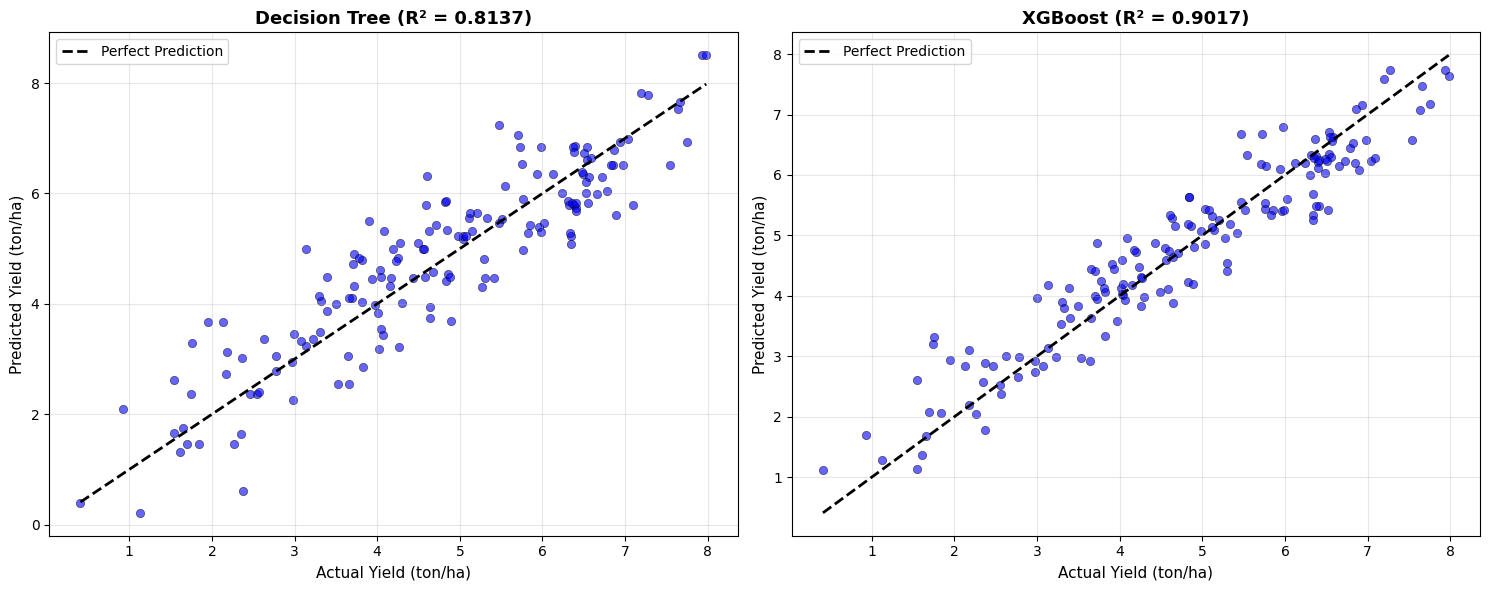

In [7]:
# Create scatter plots comparing actual vs predicted values
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for idx, (name, model) in enumerate(models.items()):
    ax = axes[idx]
    y_pred = results_df[results_df['Model'] == name]['Predictions'].values[0]
    r2 = results_df[results_df['Model'] == name]['R²'].values[0]
    
    ax.scatter(y_test, y_pred, alpha=0.6, color='blue', edgecolors='black', linewidths=0.5)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Prediction')
    ax.set_xlabel('Actual Yield (ton/ha)', fontsize=11)
    ax.set_ylabel('Predicted Yield (ton/ha)', fontsize=11)
    ax.set_title(f'{name} (R² = {r2:.4f})', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

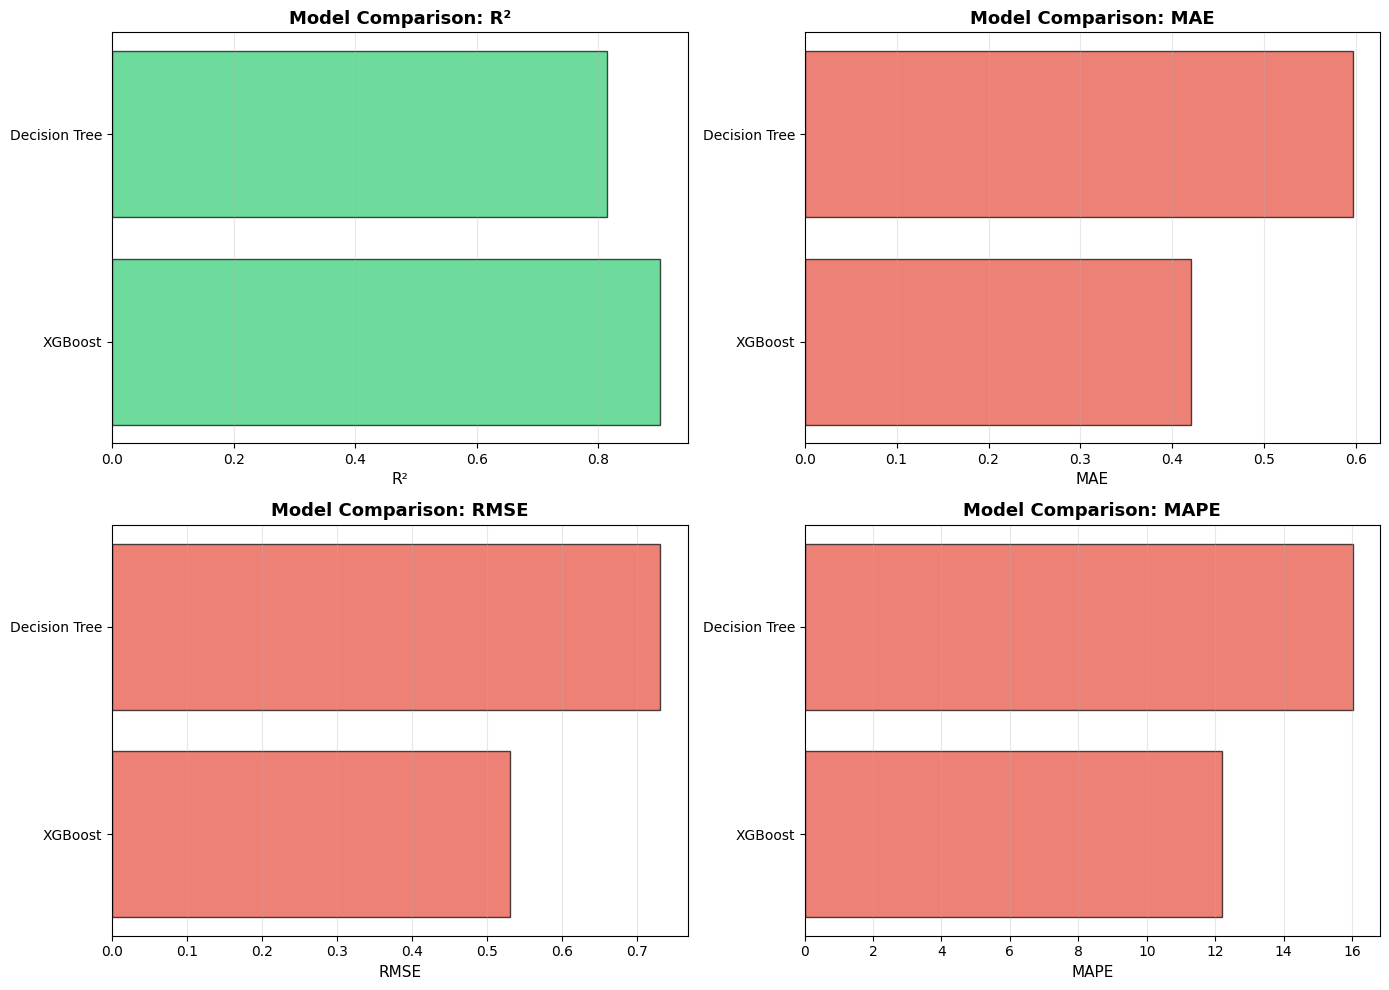

In [8]:
# Visualize model comparison across all metrics
metrics_df = results_df[['Model', 'R²', 'MAE', 'RMSE', 'MAPE']].copy()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, metric in enumerate(['R²', 'MAE', 'RMSE', 'MAPE']):
    ax = axes[idx // 2, idx % 2]
    data = metrics_df.sort_values(metric, ascending=(metric != 'R²'))
    colors = ['#2ecc71' if metric == 'R²' else '#e74c3c'] * len(data)
    ax.barh(data['Model'], data[metric], color=colors, alpha=0.7, edgecolor='black')
    ax.set_xlabel(metric, fontsize=11)
    ax.set_title(f'Model Comparison: {metric}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [9]:
# Initialize SHAP explainer for best model
best_model = models[best_model_name]

print(f"Creating SHAP analysis for {best_model_name}...\n")

# Use TreeExplainer directly for XGBoost (more stable)
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

print("✅ SHAP values computed!")

Creating SHAP analysis for XGBoost...

✅ SHAP values computed!


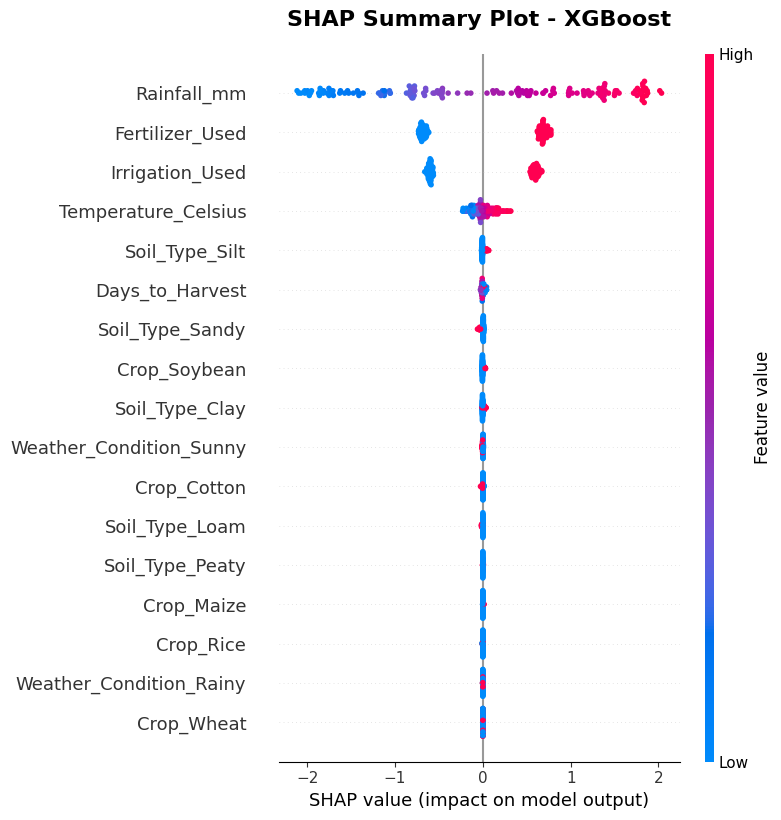


📊 Interpretasi SHAP Summary Plot:
- Fitur paling atas = paling berpengaruh terhadap prediksi
- Warna MERAH = nilai fitur tinggi
- Warna BIRU = nilai fitur rendah
- Posisi KANAN (SHAP > 0) = meningkatkan yield
- Posisi KIRI (SHAP < 0) = menurunkan yield


In [10]:
# SHAP Summary Plot - shows feature importance and impact direction
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, show=False)
plt.title(f'SHAP Summary Plot - {best_model_name}', fontsize=16, pad=20, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📊 Interpretasi SHAP Summary Plot:")
print("- Fitur paling atas = paling berpengaruh terhadap prediksi")
print("- Warna MERAH = nilai fitur tinggi")
print("- Warna BIRU = nilai fitur rendah")
print("- Posisi KANAN (SHAP > 0) = meningkatkan yield")
print("- Posisi KIRI (SHAP < 0) = menurunkan yield")

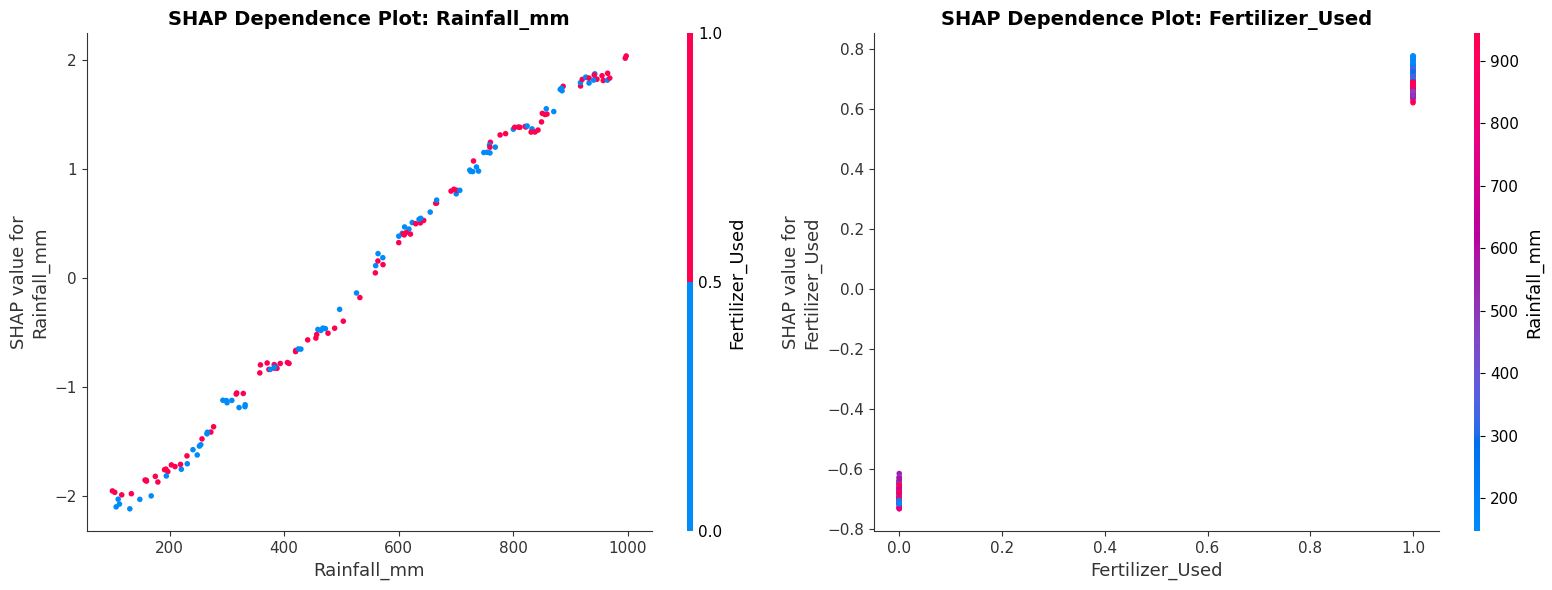


📊 Interpretasi Dependence Plot:
- Sumbu X: Nilai fitur
- Sumbu Y: SHAP value (dampak terhadap prediksi)
- Trend naik = fitur positif meningkatkan yield
- Trend turun = fitur positif menurunkan yield


In [11]:
# SHAP Dependence Plots for top 2 features
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False)

top_features = feature_importance.head(2)['feature'].values

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, feature in enumerate(top_features):
    shap.dependence_plot(
        feature,
        shap_values,
        X_test,
        ax=axes[idx],
        show=False
    )
    axes[idx].set_title(f'SHAP Dependence Plot: {feature}', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Interpretasi Dependence Plot:")
print("- Sumbu X: Nilai fitur")
print("- Sumbu Y: SHAP value (dampak terhadap prediksi)")
print("- Trend naik = fitur positif meningkatkan yield")
print("- Trend turun = fitur positif menurunkan yield")

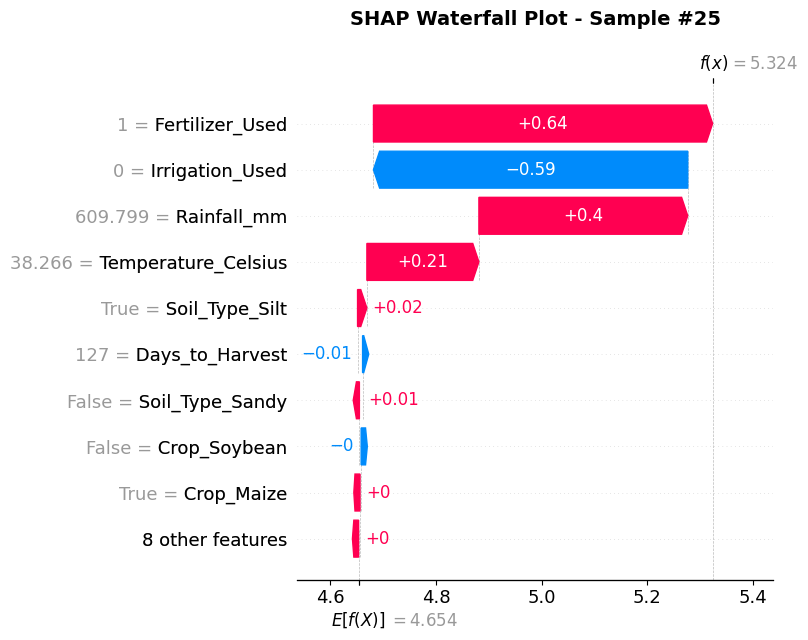


📊 Individual Prediction Explanation:
Sample Index: 25
Actual Yield: 5.11 ton/ha
Predicted Yield: 5.32 ton/ha
Base Value (average): 4.65 ton/ha

Waterfall menunjukkan bagaimana setiap fitur 'mendorong' prediksi naik/turun dari baseline


In [12]:
# SHAP Waterfall Plot for Individual Prediction
# Select a sample to explain (e.g., sample #25 from test set)
sample_idx = 25

# Create Explanation object for waterfall plot
explanation = shap.Explanation(
    values=shap_values[sample_idx],
    base_values=explainer.expected_value,
    data=X_test.iloc[sample_idx],
    feature_names=X_test.columns.tolist()
)

# Create waterfall plot
plt.figure(figsize=(10, 8))
shap.plots.waterfall(explanation, show=False)
plt.title(f'SHAP Waterfall Plot - Sample #{sample_idx}', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Print actual vs predicted for this sample
actual_value = y_test[sample_idx]
predicted_value = best_model.predict(X_test.iloc[[sample_idx]])[0]

print(f"\n📊 Individual Prediction Explanation:")
print(f"Sample Index: {sample_idx}")
print(f"Actual Yield: {actual_value:.2f} ton/ha")
print(f"Predicted Yield: {predicted_value:.2f} ton/ha")
print(f"Base Value (average): {explainer.expected_value:.2f} ton/ha")
print(f"\nWaterfall menunjukkan bagaimana setiap fitur 'mendorong' prediksi naik/turun dari baseline")

/tmp/ipykernel_10040/993416854.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10, x='importance', y='feature', palette='viridis', edgecolor='black')


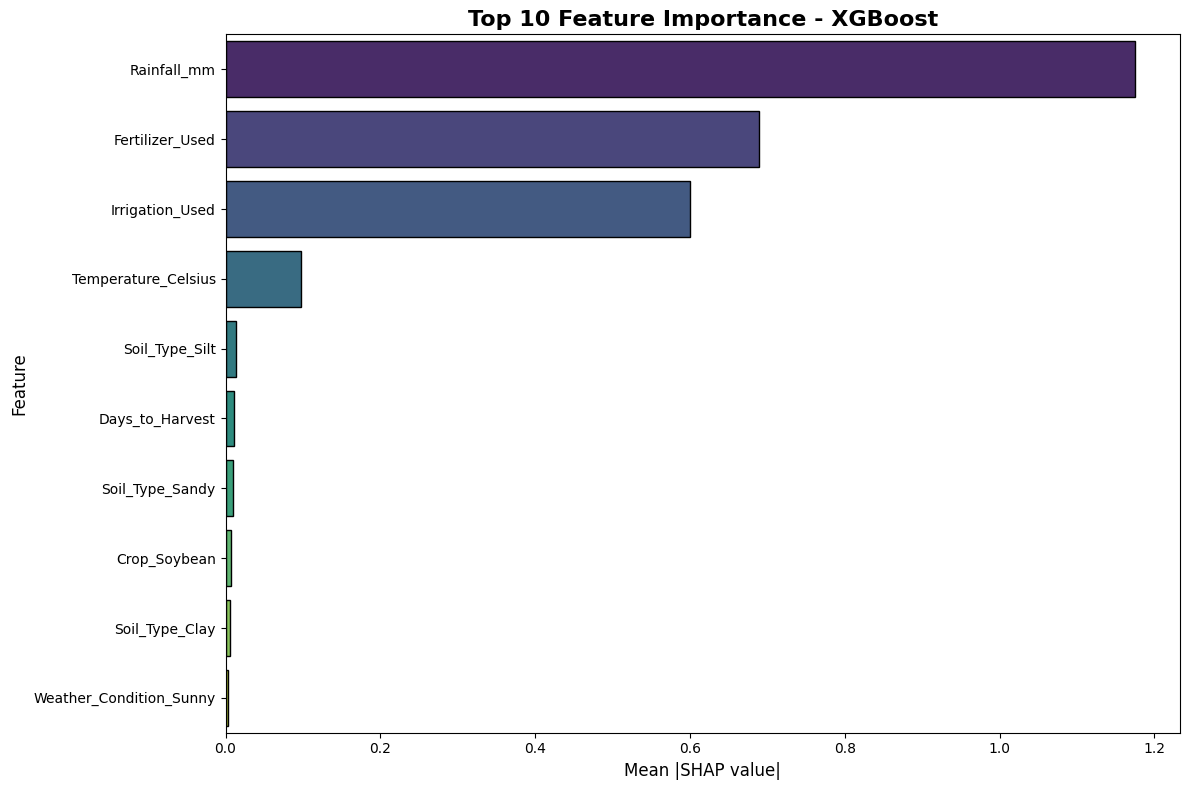


Top 10 Most Important Features:
Rainfall_mm                   : 1.1744
Fertilizer_Used               : 0.6891
Irrigation_Used               : 0.6003
Temperature_Celsius           : 0.0976
Soil_Type_Silt                : 0.0135
Days_to_Harvest               : 0.0113
Soil_Type_Sandy               : 0.0096
Crop_Soybean                  : 0.0069
Soil_Type_Clay                : 0.0061
Weather_Condition_Sunny       : 0.0027


In [13]:
# Feature Importance Bar Plot
plt.figure(figsize=(12, 8))
top_10 = feature_importance.head(10)
sns.barplot(data=top_10, x='importance', y='feature', palette='viridis', edgecolor='black')
plt.title(f'Top 10 Feature Importance - {best_model_name}', fontsize=16, fontweight='bold')
plt.xlabel('Mean |SHAP value|', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print("="*50)
for idx, row in top_10.iterrows():
    print(f"{row['feature']:30s}: {row['importance']:.4f}")
print("="*50)

In [14]:
# Save trained models for Streamlit deployment
os.makedirs('../models', exist_ok=True)

model_paths = {
    'Decision Tree': '../models/decision_tree.pkl',
    'XGBoost': '../models/xgboost_model.json'
}

print("Saving models...\n")

for name, model in models.items():
    if name == 'XGBoost':
        # Save XGBoost booster (more reliable for GridSearchCV models)
        model.get_booster().save_model(model_paths[name])
    else:
        joblib.dump(model, model_paths[name])
    print(f"✅ {name} saved to {model_paths[name]}")

# Save evaluation metrics
metrics_df.to_csv('../models/model_comparison.csv', index=False)
print("\n✅ Model metrics saved to ../models/model_comparison.csv")
print("\n🎉 All models ready for Streamlit deployment!")

Saving models...

✅ Decision Tree saved to ../models/decision_tree.pkl
✅ XGBoost saved to ../models/xgboost_model.json

✅ Model metrics saved to ../models/model_comparison.csv

🎉 All models ready for Streamlit deployment!
